<a href="https://colab.research.google.com/github/Eunhye1109/Practical-Project/blob/EH/%EA%B8%B0%EC%97%85%EB%AA%85_%EA%B2%80%EC%83%89_%EC%8B%9C_3%EA%B0%9C%EB%85%84_%EA%B3%A0%EC%9A%A9%EC%9E%90_%26_%EA%B8%89%EC%97%AC_%EA%B7%B8%EB%9E%98%ED%94%84_%EC%9E%90%EB%8F%99_%EC%B6%94%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install dart-fss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0


In [2]:
#2. rcept_no를 이용

In [3]:
import requests

api_key = '' #api key 삭제
corp_code = '00126380'
url = f'https://opendart.fss.or.kr/api/list.json?crtfc_key={api_key}&corp_code={corp_code}&page_count=10'

response = requests.get(url)
data = response.json()

# 최근 공시 목록 확인
if data.get('status') == '013':
    print("해당 기업의 공시 정보가 없습니다.")
elif 'list' in data:
    for report in data['list']:
        print(f"보고서명: {report['report_nm']} / 접수번호: {report['rcept_no']} / 날짜: {report['rcept_dt']}")
else:
    print("에러 발생:", data)


해당 기업의 공시 정보가 없습니다.


In [4]:
import requests
import pandas as pd
import time

# 인증키
API_KEY = 'a8595790e77447b84efbb957beac67afdf402347'

# 조회 연도 및 보고서 코드
YEARS = ['2021', '2022', '2023']
REPRT_CODE = ['11011', '11012', '11013', '11014']  # 사업보고서

# 분석 대상 기업 리스트 (예: 삼성전자)
corp_code = '00126380'
corp_codes = {
    '삼성전자': corp_code
}

# 관심 있는 항목 키워드
target_keywords = ['급여', '보수', '직원수', '인건비', '종업원수', '총급여']

def fetch_dart_data(corp_code, year, report_code):
    url = 'https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json'
    params = {
        'crtfc_key': API_KEY,
        'corp_code': corp_code,
        'bsns_year': year,
        'reprt_code': report_code,
        'fs_div': 'CFS'  # 연결 재무제표
    }
    response = requests.get(url, params=params)
    return response.json()

# ✅ 결과 저장용 리스트
results = []

for corp_name, corp_code in corp_codes.items():
    for year in YEARS:
        data = fetch_dart_data(corp_code, year, REPRT_CODE)
        time.sleep(0.3)

        if data['status'] != '013':  # '013': 공시 없음
            for item in data.get('list', []):
                account = item.get('account_nm', '')
                for keyword in target_keywords:
                    if keyword in account:
                        results.append({
                            'corp_name': corp_name,
                            'corp_code': corp_code,
                            'year': year,
                            'account_nm': account,
                            'amount': item.get('thstrm_amount', '').replace(',', ''),
                        })

# ✅ 데이터프레임 변환 및 정제
df = pd.DataFrame(results)
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').fillna(0)

# ✅ 피벗: 기업-연도별 항목 값
df_pivot = df.pivot_table(
    index=['corp_name', 'year'],
    columns='account_nm',
    values='amount',
    aggfunc='sum'
).reset_index()

display(df_pivot)


account_nm,corp_name,year,순확정급여부채,순확정급여부채(자산) 재측정요소,순확정급여자산
0,삼성전자,2021,465884000000,-2094370000000,2809590000000
1,삼성전자,2022,268370000000,4583404000000,5851972000000
2,삼성전자,2023,456557000000,-3282810000000,4905219000000


In [5]:
import requests
import pandas as pd
import time

API_KEY = 'a8595790e77447b84efbb957beac67afdf402347'
YEARS = ['2023', '2022', '2021']
REPRT_CODE = '11011'

corp_codes = {
    '삼성전자': '00126380',
    'SK하이닉스': '00164742',
}

def fetch_emp_status(corp_code, year):
    url = "https://opendart.fss.or.kr/api/empSttus.json"
    params = {
        'crtfc_key': API_KEY,
        'corp_code': corp_code,
        'bsns_year': year,
        'reprt_code': REPRT_CODE
    }
    res = requests.get(url, params=params)
    return res.json()

results = []

for corp_name, corp_code in corp_codes.items():
    for year in YEARS:
        data = fetch_emp_status(corp_code, year)
        time.sleep(0.3)

        if data.get('status') == '000' and 'list' in data:
            for row in data['list']:
                results.append({
                    '기업명': corp_name,
                    '연도': year,
                    '성별': row.get('sexdstn'),
                    '부서': row.get('fo_bbm'),
                    '정규직 수': row.get('rgllbr_co'),
                    '계약직 수': row.get('cnttk_co'),
                    '총인원 수': row.get('sm'),
                    '총급여액(천원)': row.get('fyer_salary_totamt'),
                    '1인 평균급여(천원)': row.get('jan_salary_am')
                })

df = pd.DataFrame(results)

# 문자열 → 숫자 변환
for col in ['정규직 수', '계약직 수', '총인원 수', '총급여액(천원)', '1인 평균급여(천원)']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '').replace('-', ''), errors='coerce')

# 결과 확인
print(df.head())
df.to_csv('dart_직원급여_정리.csv', index=False, encoding='utf-8-sig')


    기업명    연도 성별    부서  정규직 수  계약직 수  총인원 수      총급여액(천원)  1인 평균급여(천원)
0  삼성전자  2023  남    DX  37962    324  38286           NaN          NaN
1  삼성전자  2023  여    DX  12202     97  12299           NaN          NaN
2  삼성전자  2023  남    DS  53372    148  53520           NaN          NaN
3  삼성전자  2023  여    DS  20671     28  20699           NaN          NaN
4  삼성전자  2023  남  성별합계  91334    472  91806  1.153049e+13  128000000.0


In [6]:
# 1. 전체 성별합계 필터링 후 내용 확인
subset = df[df['성별'] == '성별합계'].copy()
print("✅ subset row count:", len(subset))
print(subset[['연도', '총인원 수', '총급여액(천원)']].head(10))

# 2. 숫자 변환 후 확인
subset['연도'] = pd.to_numeric(subset['연도'], errors='coerce')
subset['총인원 수'] = pd.to_numeric(subset['총인원 수'], errors='coerce')
subset['총급여액(천원)'] = pd.to_numeric(subset['총급여액(천원)'], errors='coerce')

subset['avg_salary'] = subset['총급여액(천원)'] / subset['총인원 수']
print("✅ 연도 + 평균급여:")
print(subset[['연도', 'avg_salary']].dropna())


✅ subset row count: 0
Empty DataFrame
Columns: [연도, 총인원 수, 총급여액(천원)]
Index: []
✅ 연도 + 평균급여:
Empty DataFrame
Columns: [연도, avg_salary]
Index: []


✅ 연도 + 평균급여:
     연도    avg_salary
0  2021  7.603969e+07
1  2022  7.368209e+07
2  2023  7.151999e+07


/tmp/ipython-input-7-4281760967.py:36: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-7-4281760967.py:36: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


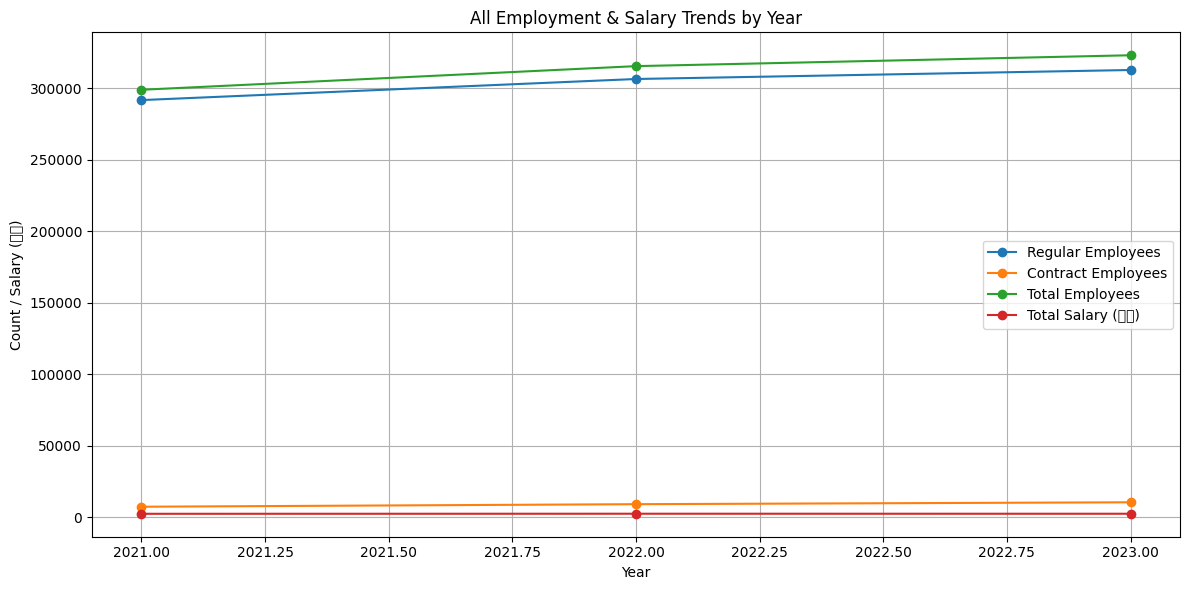

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 성별합계가 없는 경우: 직접 연도별 합계 집계
df['연도'] = pd.to_numeric(df['연도'], errors='coerce')
df['정규직 수'] = pd.to_numeric(df['정규직 수'], errors='coerce')
df['계약직 수'] = pd.to_numeric(df['계약직 수'], errors='coerce')
df['총인원 수'] = pd.to_numeric(df['총인원 수'], errors='coerce')
df['총급여액(천원)'] = pd.to_numeric(df['총급여액(천원)'], errors='coerce')

# ✅ 연도별 집계 (성별 상관없이 합산)
df_summary = df.groupby('연도')[['정규직 수', '계약직 수', '총인원 수', '총급여액(천원)']].sum().reset_index()

# ✅ 평균급여 계산
df_summary['avg_salary'] = df_summary['총급여액(천원)'] / df_summary['총인원 수']
print("✅ 연도 + 평균급여:")
print(df_summary[['연도', 'avg_salary']].dropna())

# ✅ 모든 항목을 꺾은선 그래프에 출력
plt.figure(figsize=(12, 6))

# 정규직, 계약직, 총인원 수: 그대로
plt.plot(df_summary['연도'], df_summary['정규직 수'], marker='o', label='Regular Employees')
plt.plot(df_summary['연도'], df_summary['계약직 수'], marker='o', label='Contract Employees')
plt.plot(df_summary['연도'], df_summary['총인원 수'], marker='o', label='Total Employees')

# 총급여: 천원 단위를 억 원으로 변환
plt.plot(df_summary['연도'], df_summary['총급여액(천원)'] / 10000000000, marker='o', label='Total Salary (억원)')

# 그래프 스타일 설정
plt.title('All Employment & Salary Trends by Year')
plt.xlabel('Year')
plt.ylabel('Count / Salary (억원)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
import xml.etree.ElementTree as ET
import requests

def load_corp_codes():
    url = f'https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={API_KEY}'
    res = requests.get(url)

    # 파일을 바이너리로 저장
    with open('corp_code.xml', 'wb') as f:
        f.write(res.content)

    # XML 파싱
    tree = ET.parse('corp_code.xml')
    root = tree.getroot()

    corp_map = {}
    for child in root.findall('list'):
        name = child.find('corp_name').text.strip()
        code = child.find('corp_code').text.strip()
        corp_map[name] = code

    return corp_map


In [2]:
import requests
import zipfile
import io
import xml.etree.ElementTree as ET

def load_corp_codes():
    url = f"https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={API_KEY}"
    response = requests.get(url)

    # ✅ zip 압축 해제
    with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
        with zf.open('CORPCODE.xml') as xml_file:
            tree = ET.parse(xml_file)
            root = tree.getroot()

    corp_map = {}
    for child in root.findall('list'):
        name = child.find('corp_name').text.strip()
        code = child.find('corp_code').text.strip()
        corp_map[name] = code

    return corp_map



In [ ]:
import requests
import zipfile
import io
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

API_KEY = '' #api_key 추가
REPRT_CODE = '11011'
YEARS = ['2023', '2022', '2021']
SAVE_DIR = 'dart_charts'

# ✅ 1. DART corp_code.zip 파싱
def load_corp_codes():
    print("📦 corp_code 목록 다운로드 중...")
    url = f"https://opendart.fss.or.kr/api/corpCode.xml?crtfc_key={API_KEY}"
    response = requests.get(url)
    if response.status_code != 200:
        print("❌ 요청 실패: status =", response.status_code)
        return {}

    with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
        with zf.open('CORPCODE.xml') as xml_file:
            tree = ET.parse(xml_file)
            root = tree.getroot()

    corp_map = {}
    for child in root.findall('list'):
        name = child.find('corp_name').text.strip()
        code = child.find('corp_code').text.strip()
        corp_map[name] = code

    print(f"✅ 총 기업 수: {len(corp_map):,}개")
    return corp_map

# ✅ 2. 직원현황 API
def fetch_emp_status(corp_code, year):
    url = "https://opendart.fss.or.kr/api/empSttus.json"
    params = {
        'crtfc_key': API_KEY,
        'corp_code': corp_code,
        'bsns_year': year,
        'reprt_code': REPRT_CODE
    }
    res = requests.get(url, params=params)
    return res.json()

# ✅ 3. 그래프 생성 및 저장
def plot_and_save(df, corp_name):
    df = df.groupby('연도')[['정규직 수', '계약직 수', '총인원 수', '총급여액(천원)']].sum().reset_index()
    df['평균급여'] = df['총급여액(천원)'] / df['총인원 수']

    print(f"📊 {corp_name} - 평균급여 계산 결과:\n{df[['연도', '평균급여']]}")

    plt.figure(figsize=(10, 6))
    plt.plot(df['연도'], df['정규직 수'], marker='o', label='Regular')
    plt.plot(df['연도'], df['계약직 수'], marker='o', label='Contract')
    plt.plot(df['연도'], df['총인원 수'], marker='o', label='Total Employees')
    plt.plot(df['연도'], df['총급여액(천원)'] / 1_000_000_000, marker='o', label='Total Salary (조 KRW)')

    plt.title(f'{corp_name} Employment & Salary Trend')
    plt.xlabel('Year')
    plt.ylabel('Count / Salary (조 KRW)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    os.makedirs(SAVE_DIR, exist_ok=True)
    filepath = f"{SAVE_DIR}/{corp_name}_chart.png"
    plt.savefig(filepath, dpi=300)
    plt.close()
    print(f"[✅ 저장 완료] {filepath}\n")

# ✅ 4. 메인 실행
if __name__ == "__main__":
    user_input = input("기업명을 ,(콤마)로 구분해서 입력하세요 (예: 삼성전자,카카오,네이버):\n")
    customer_input_names = [name.strip() for name in user_input.split(',') if name.strip()]
    print(f"🎯 입력된 기업 수: {len(customer_input_names)}개")

    corp_map = load_corp_codes()

    for corp_name in customer_input_names:
        print(f"\n🔍 처리 중: {corp_name}")
        corp_code = corp_map.get(corp_name)
        if not corp_code:
            print(f"❌ corp_code 미발견 → '{corp_name}'은 등록되지 않았습니다.")
            continue

        records = []
        for year in YEARS:
            print(f"📅 {year} 데이터 조회 중...")
            data = fetch_emp_status(corp_code, year)
            time.sleep(0.3)
            if data.get('status') == '000' and data.get('list'):
                for row in data['list']:
                    records.append({
                        '연도': int(year),
                        '정규직 수': row.get('rgllbr_co'),
                        '계약직 수': row.get('cnttk_co'),
                        '총인원 수': row.get('sm'),
                        '총급여액(천원)': row.get('fyer_salary_totamt')
                    })
            else:
                print(f"⚠️ {year}년도 공시 없음 or 오류 메시지: {data.get('message')}")

        df = pd.DataFrame(records)
        if df.empty:
            print(f"⚠️ {corp_name} - 사용 가능한 직원 공시 데이터 없음")
            continue

        for col in ['정규직 수', '계약직 수', '총인원 수', '총급여액(천원)']:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '').replace('-', ''), errors='coerce')

        print(f"📄 {corp_name} 정제된 데이터 미리보기:\n{df.head()}")
        plot_and_save(df, corp_name)


In [ ]:
import os
print(os.getcwd())